
<a name="T_B0700E75"></a>
# <span style="color:rgb(213,80,0)">Access data from Open Microscopy database</span>

Authors: Shubo Chakrabarti & Thomas Künzel


Copyright 2023 The MathWorks Inc

<a name="beginToc"></a>
## Table of Contents
[Introduction](#H_C62AE357)

[Access the data from Open Microscopy](#H_0C89D501)

&emsp;[Access a list of all publicly available projects](#H_FE3D5977)

&emsp;[Access metadata on one single project](#H_2867209D)

&emsp;[Access single dataset from project](#H_C9E9629A)

&emsp;[Access individual microscopy images from dataset](#H_207B8A5B)

&emsp;[Simple Cell Counting (in the Image chosen above)](#H_7227C591)

[Publish reusable MATLAB code for reproducible results](#H_2C04E455)

<a name="endToc"></a>
<a name="H_C62AE357"></a>
## Introduction

 **Public Data:** Many public databases have been created for the purposes of making data freely accessible to the scientific community. A best practice is to assign a unique identifier to a dataset, so that it is discoverable. A common form of a unique identifier is a [Digital Object Identifier or DOI](https://en.wikipedia.org/wiki/Digital_object_identifier) which points to the data.


**Access Public Data:** To access and process public data, you can use several routes.

-  Download data files to your local machine and work with them in MATLAB.
-  Access data directly via an API. MATLAB's [<samp>webread</samp>](https://www.mathworks.com/help/matlab/ref/webread.html?searchHighlight=webread&s_tid=srchtitle_webread_1) function reads the RESTful API used by many portals.
-  If the portal offers only Python bindings, [call Python from MATLAB](https://www.mathworks.com/help/matlab/call-python-libraries.html).

**Data formats:** MATLAB supports a wide range of data formats

-  There are a wide range of scientific data formats that can be [natively read in MATLAB](https://www.mathworks.com/help/matlab/scientific-data.html). They include NetCDF and HDF5 as well as more specialized data formats.
-  In addition, the [Bioinformatics Toolbox](https://www.mathworks.com/products/bioinfo.html) contains [built-in functions](https://www.mathworks.com/help/bioinfo/ug/data-formats-and-databases.html) to read data from many online data repositories in standard bioinformatics data formats.
-  Sometimes data import functions may be [written by the community](https://www.mathworks.com/matlabcentral/fileexchange?q=data+read), and published on the MATLAB [File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/) - a portal for community contributions in MATLAB. All community contributions are covered by open source licenses, which means they can be re-used, modified or added to. Exact terms and conditions depend on the licenses used by the authors.

In this example, we will access microscopy data from the Image Data Resource (IDR) on the [Open Microscopy database](https://idr.openmicroscopy.org/).

<a name="H_0C89D501"></a>
## Access the data from Open Microscopy
<a name="H_FE3D5977"></a>
### Access a list of all publicly available projects

Clear the workspace


In [1]:
clearvars; clc


Construct some url addresses to query the data


In [2]:
baseUrl = "https://idr.openmicroscopy.org"; % main portal
projectsUrl = baseUrl + "/webgateway/proj/list/"; % list of projects


Read in all the projects available on the database into a [table](https://www.mathworks.com/help/matlab/ref/table.html)


In [3]:
projects = webread(projectsUrl);
projectTable = struct2table(projects)


Some rows have */experiment* as a suffix to their names. These are projects containing actual data. Only display these and sort them by their IDs


In [4]:
projectTable = projectTable(contains(projectTable.name,"/experiment"),:);
sortrows(projectTable,"id")


Convert the text into the datatype string for easier indexing and manipulation


In [5]:
projectTable.name = string(projectTable.name);
projectTable.description = string(projectTable.description);


Write project table to excel file


In [6]:
writetable(projectTable,"projectTable.xlsx");

<a name="H_2867209D"></a>
### Access metadata on one single project

First, extract the descriptions of each project


In [7]:
descriptions = strings(height(projectTable),1);
for ii = 1:length(descriptions)
    prjMetadata = splitlines(projectTable.description(ii));
    descriptions(ii) = string(prjMetadata(2));
end



Let the user choose from a list of projects


In [8]:
thisProject = descriptions(87);
projectMatches = projectTable(descriptions==thisProject,:);



If multiple experiments correspond to one project, let the user choose the experiment


In [9]:
if height(projectMatches) > 1
    ExptNames = projectMatches.name;
    ExptNames = split(ExptNames,"/");
    ExptNames = ExptNames(:,2);
    selectedExpt = ExptNames(1);
    projectMatches = projectMatches(contains(projectMatches.name,selectedExpt),:);
end

thisProject = projectMatches.id;


Query this particular project and list all the metadata associated with that project


In [10]:
projectInfoUrl = baseUrl + "/webgateway/proj/"+num2str(thisProject)+"/detail/";
projectInfo = webread(projectInfoUrl);
projectInfo.description = splitlines(projectInfo.description);
projectInfo.PublicationTitle = string(projectInfo.description(2));
projectInfo.description = string(projectInfo.description(5))

projectInfo = 
                type: 'Project'
                  id: 2251
                name: 'idr0123-mota-mifish/experimentA'
         description: "Datasets 1 and 2 are replicates of the same experimental design which consists of 16 probes targeting 16 consecutive loci on chromosome 2 using iFISH4U. The 16 probes targeting different loci are spaced with 3 or 20 Mb in order to study relatively small genomic distances and compare them with larger distances. Furthermore, 10 loci are made by a combination of two colours alternating within the locus and 6 loci have only one colour. Dataset 3 is a single colour experiment where one probe with alternated colours (AF488-AF594) was tested together with other two probes in different colours located in distinct genomic sites. There is 1 probe with AF488 dye, 1 probe with AT542, 1 probe with AF594 and 1 probe with AT647N. Dataset 4 is a single colour experiment where one probe with alternated colours (AT542-AT647N) was tested together with tw


Often, projects (and datasets and images) can be accompanied by further **annotations**. Let's read the annotations attached to this project:


In [11]:
allAnnotations = webread(baseUrl + "/webclient/api/annotations/?project=" + num2str(projectInfo.id));


Take the first annotation ("MapAnnotationI") containing the metadata related to the project including the publication DOI and turn it into a dictionary using the MATLAB function <samp>dictionary</samp>


In [12]:
annotationValues = horzcat(allAnnotations.annotations{1}.values{:});
annotationValues = cellfun(@string, annotationValues);
annotationDictionary = dictionary(annotationValues(1,:),annotationValues(2,:))

annotationDictionary = 
  dictionary (string ⟼ string) with 13 entries:
    "Sample Type"         ⟼ "cell"
    "Organism"            ⟼ "Homo sapiens"
    "Study Type"          ⟼ "fluorescence in situ hybridization"
    "Imaging Method"      ⟼ "epifluorescence microscopy"
    "Publication Title"   ⟼ "Simultaneous visualization of DNA loci in single cells by combinatorial multi-color iFISH"
    "Publication Authors" ⟼ "Mota A, Schweitzer M, Wernersson E, Crosetto N, Bienko M"
    "PubMed ID"           ⟼ "35145120 https://www.ncbi.nlm.nih.gov/pubmed/35145120"
    "Publication DOI"     ⟼ "10.1038/s41597-022-01139-2 https://doi.org/10.1038/s41597-022-01139-2"
    "Release Date"        ⟼ "2022-02-28"
    "License"             ⟼ "CC BY 4.0 https://creativecommons.org/licenses/by/4.0/"
    "Copyright"           ⟼ "Mota et al"
    "Data Publisher"      ⟼ "University of Dundee"
    "Annotation File"     ⟼ "idr0123-experimentA-annotation.csv https://github.com/IDR/idr0123-mota-mifish/blob/HEAD/ex


Next, we read in all the datasets related to this project


In [13]:
projectDatasetUrl = baseUrl + "/webgateway/proj/"+num2str(thisProject)+"/children/";
datasets = webread(projectDatasetUrl)

<a name="H_C9E9629A"></a>
### Access single dataset from project

Access data from a single dataset selected from the above table


In [14]:
thisDatasetNames = string({datasets.name}');
datasetName = thisDatasetNames(8);
datasetID = datasets(thisDatasetNames==datasetName).id

datasetID = 16558

<a name="H_207B8A5B"></a>
### Access individual microscopy images from dataset

Accessing this dataset yields its metadata...


In [15]:
datasetInfo = webread(baseUrl + "/webgateway/dataset/"+string(datasetID)+"/detail/")

datasetInfo = 
           type: 'Dataset'
             id: 16558
           name: '8_iFISH chr10 spotting Replicate 1'
    description: ''


...and all images associated with this dataset


In [16]:
datasetImages = webread(baseUrl + "/webgateway/dataset/"+string(datasetID)+"/children/");
datasetImages = struct2table(datasetImages,"AsArray",true)


There are two ways to access these images.

1.  Accessing the thumbnails - these are smaller in size and available by querying the url specified in the related <samp>thumb_url</samp> variable of the <samp>datasetImages</samp> table
2. Accessing the full image by its ID

First, load all the image thumbnails for a visual inspection



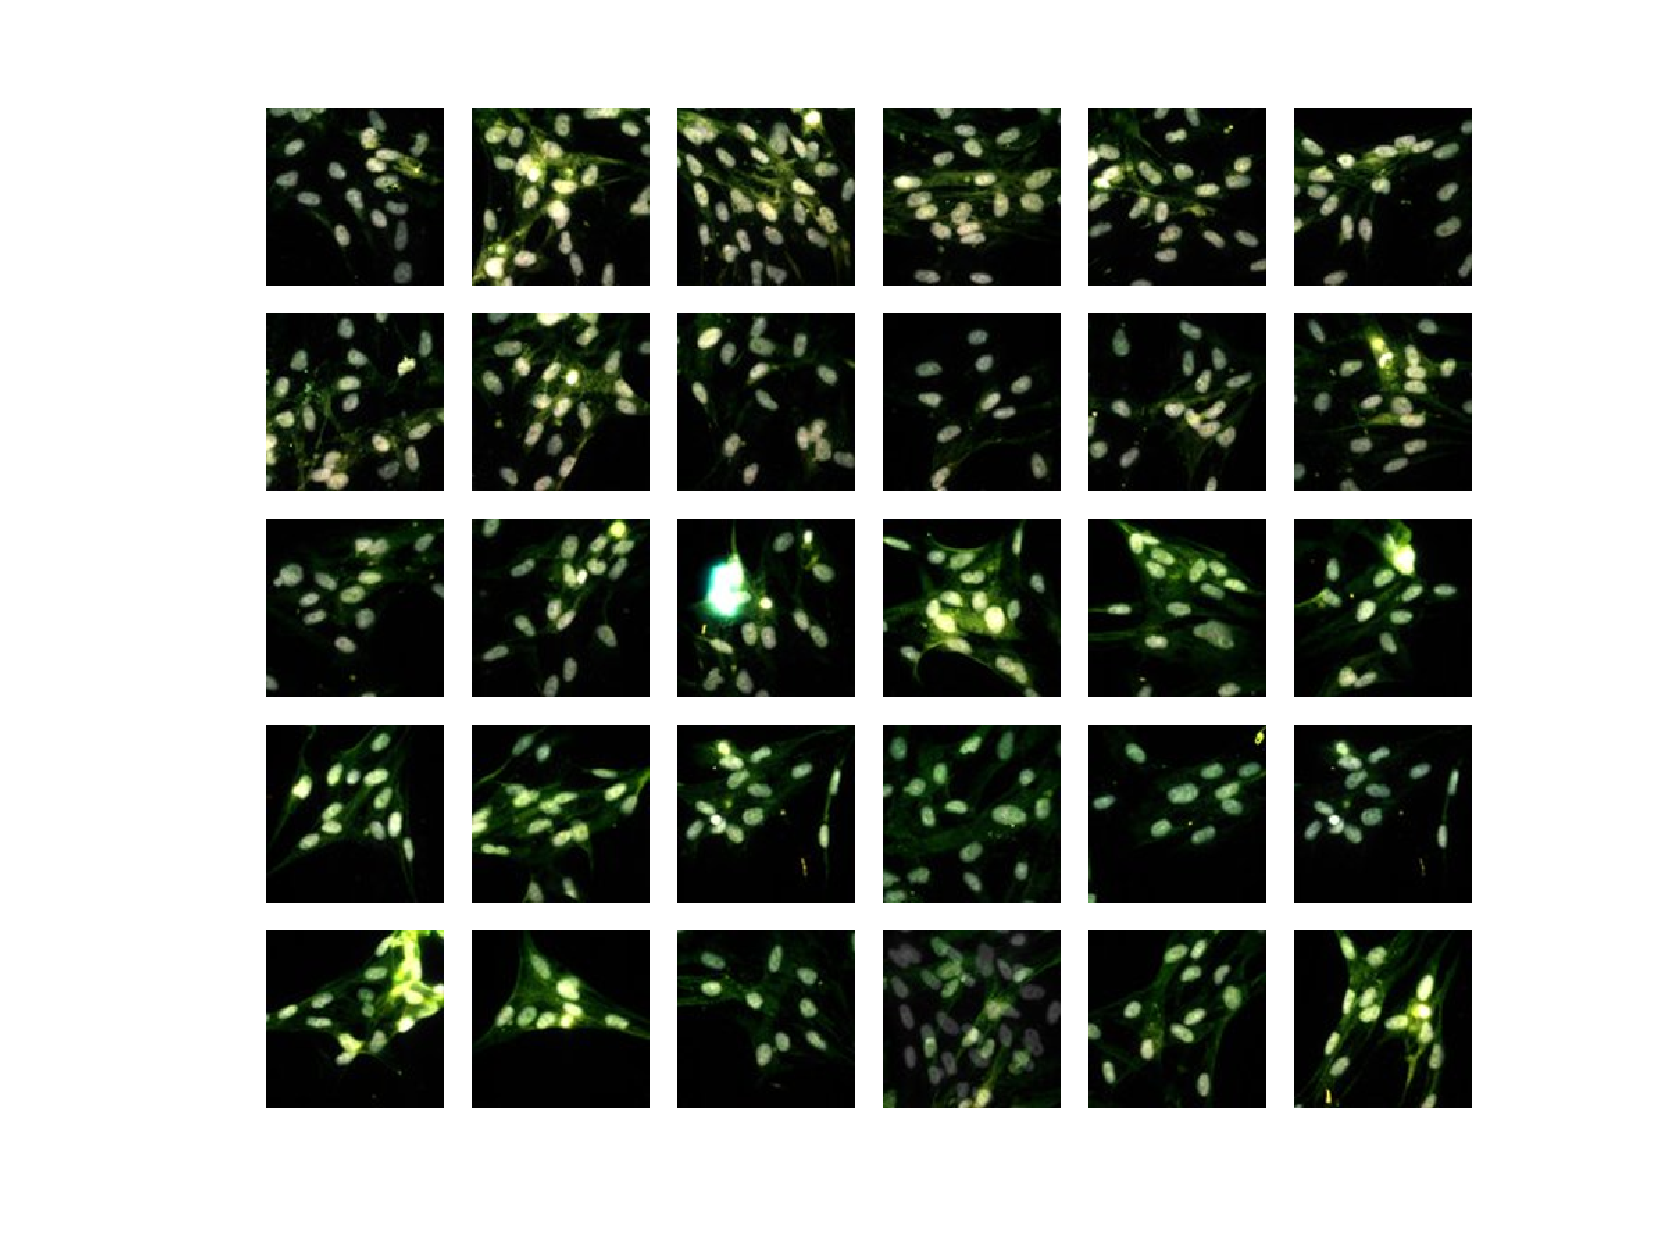

In [17]:
datasetImages.thumb_url = string(datasetImages.thumb_url);
nImagesInDataset = height(datasetImages);
thumb = cell(1, nImagesInDataset); % preallocate memory for cell array
for thisImage = 1:nImagesInDataset
    thumb{thisImage} = webread(baseUrl + datasetImages.thumb_url(thisImage));
end
figure
montage(thumb,"BorderSize",10,"BackgroundColor","white","ThumbnailSize",[128 128]);


Next, load a single full image from the selected dataset to look at it more closely. For this, you need the image number from the above montage



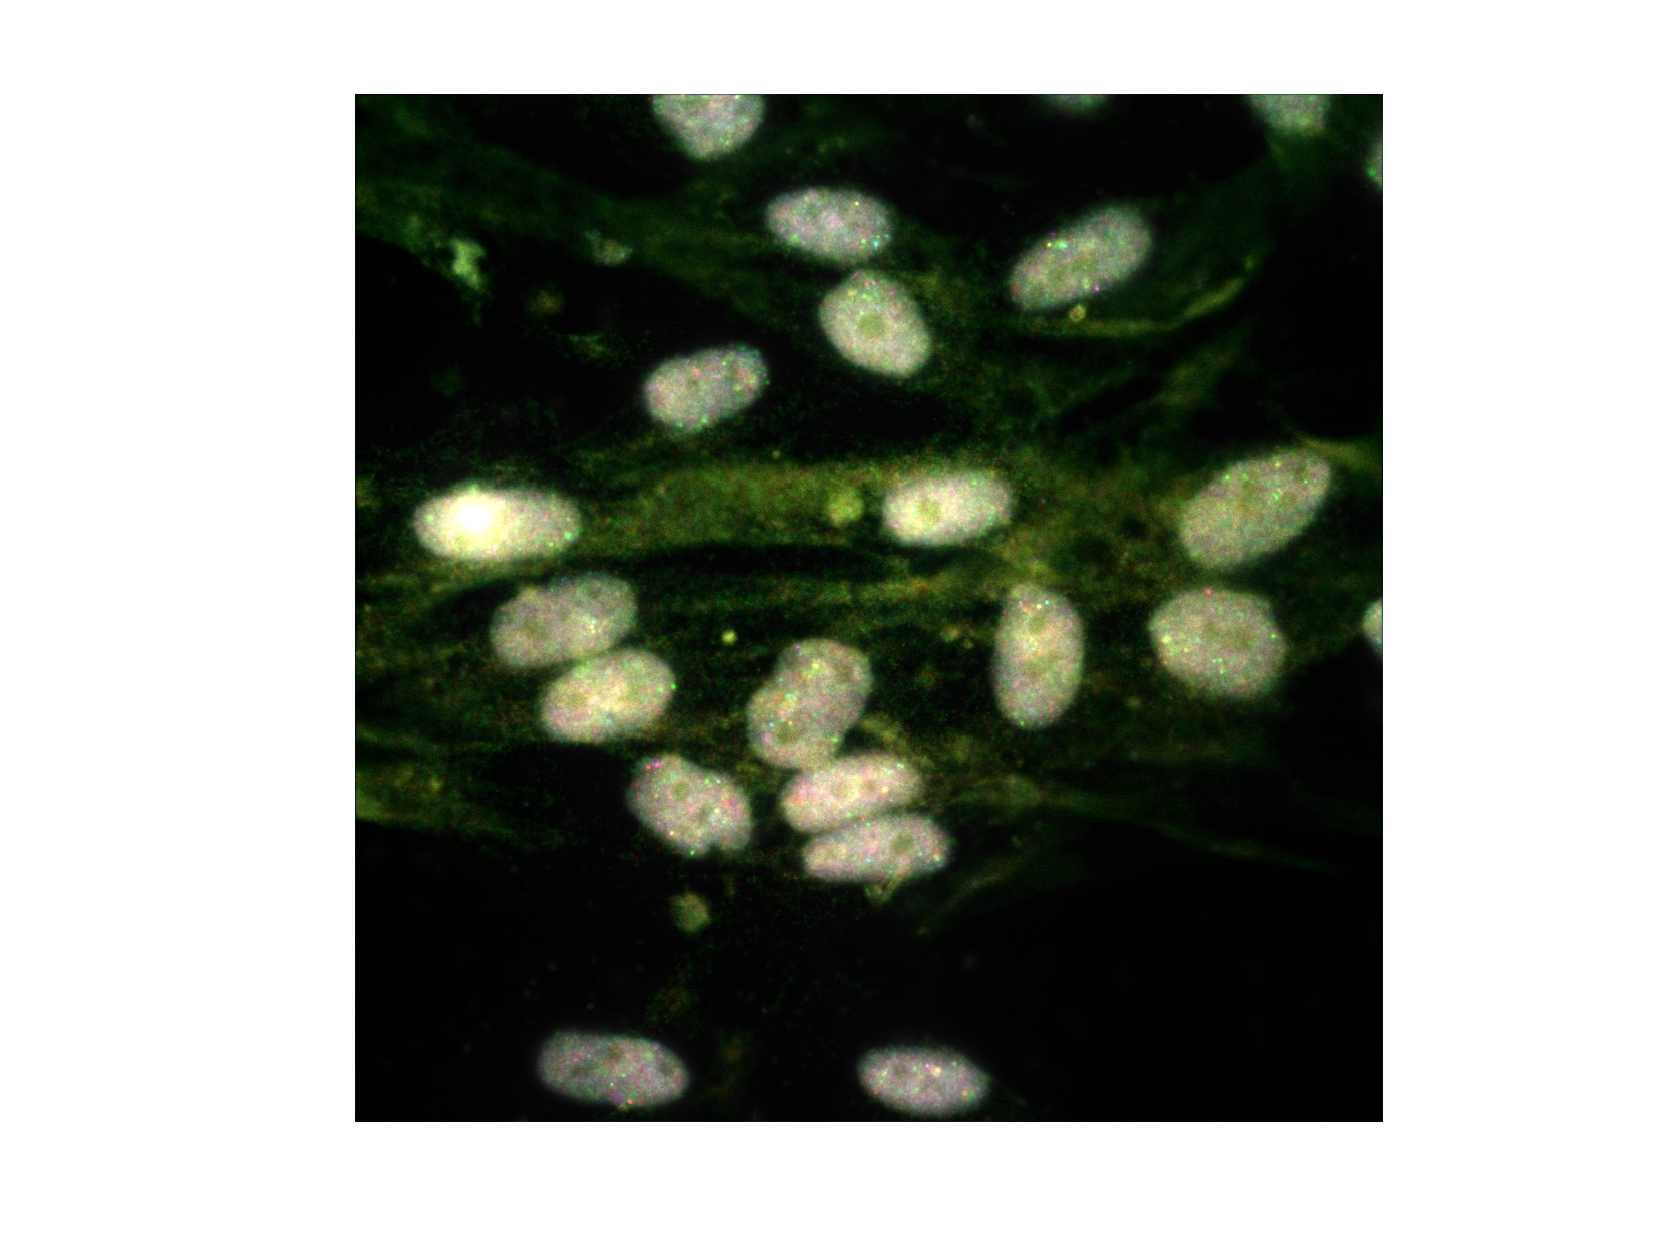

In [18]:
thisImage = 4;
thisImageUrl = baseUrl + "/webgateway/render_image/"+string(datasetImages.id(thisImage));
fullImage = webread(thisImageUrl);
figure
imshow(fullImage)

<a name="H_7227C591"></a>
### Simple Cell Counting (in the Image chosen above)

Use a very simple thresholding method to count cells in images.


First, convert the image to a grayscale image using the function <samp>im2gray</samp>



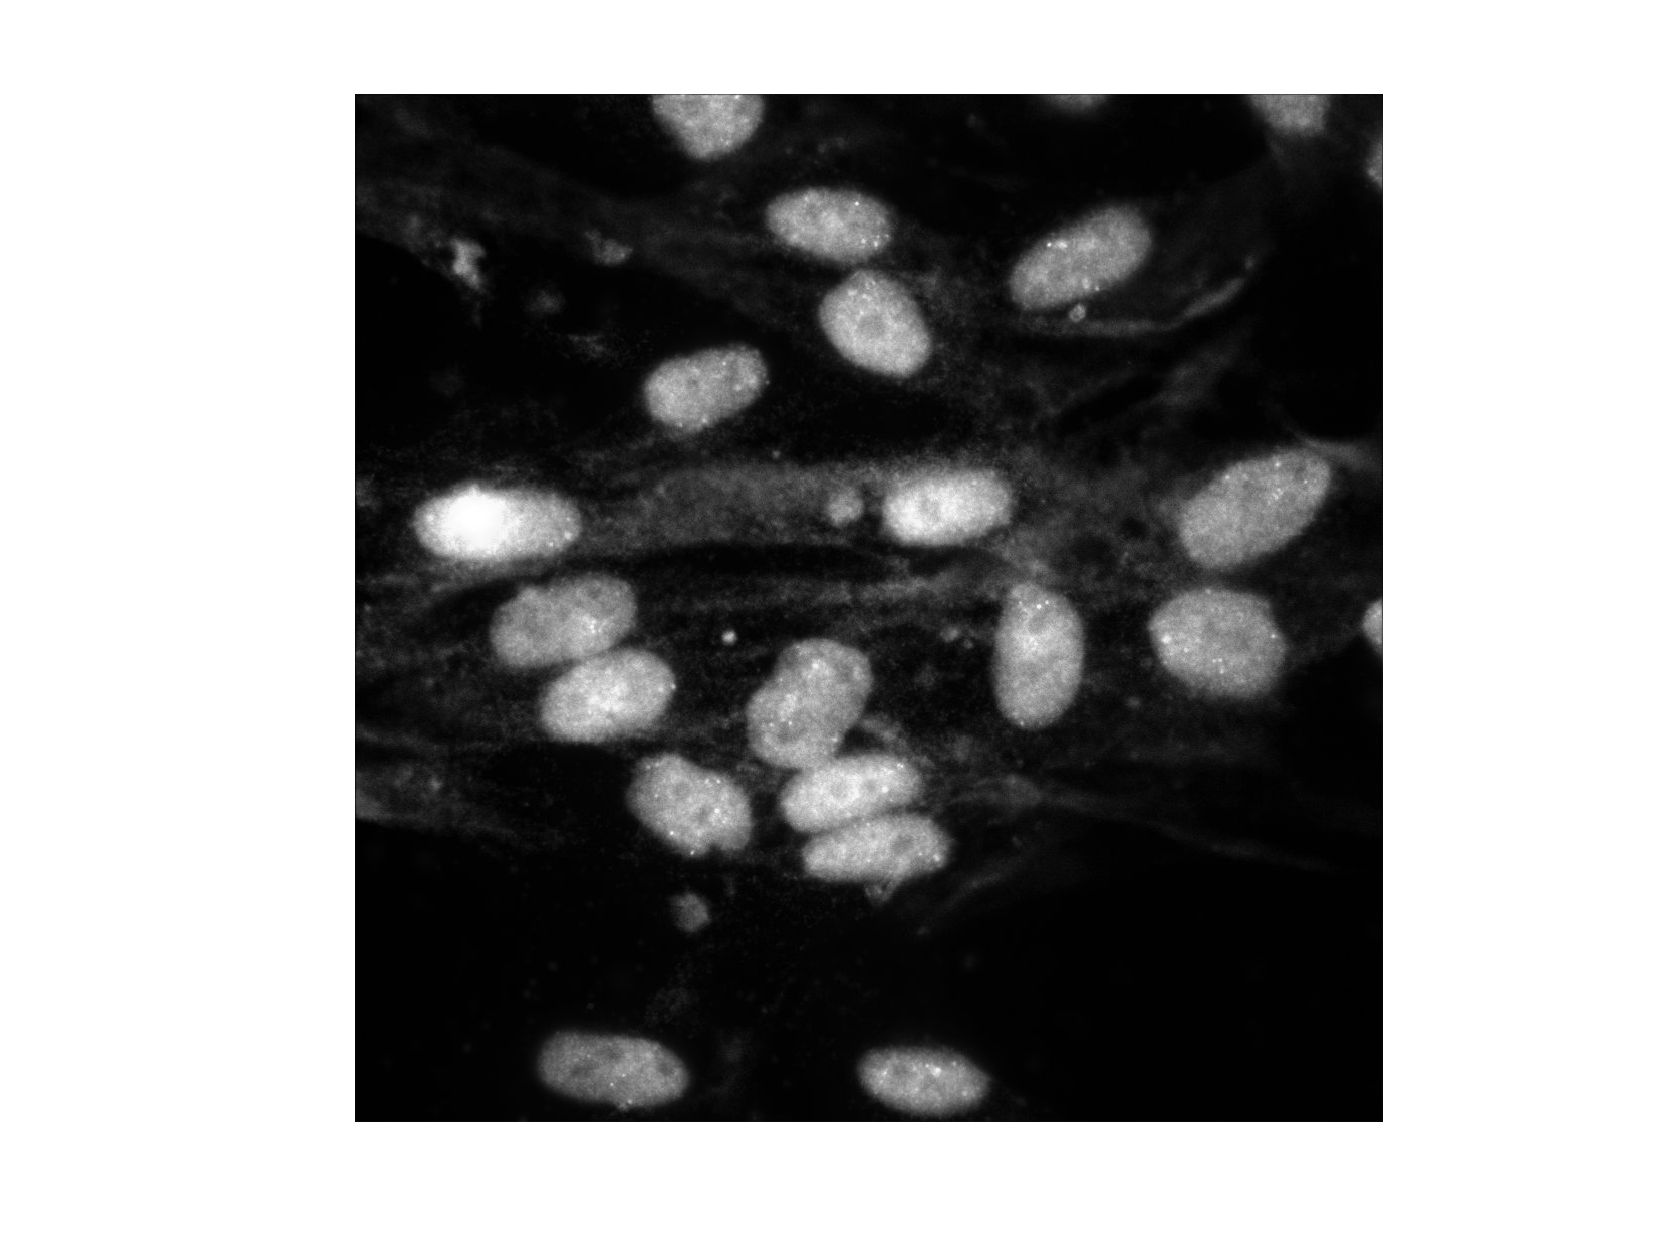

In [19]:
grayImage = im2gray(fullImage);
figure
imshow(grayImage)


Next, convert the grayscale image to a binary image using a user-specified threshold



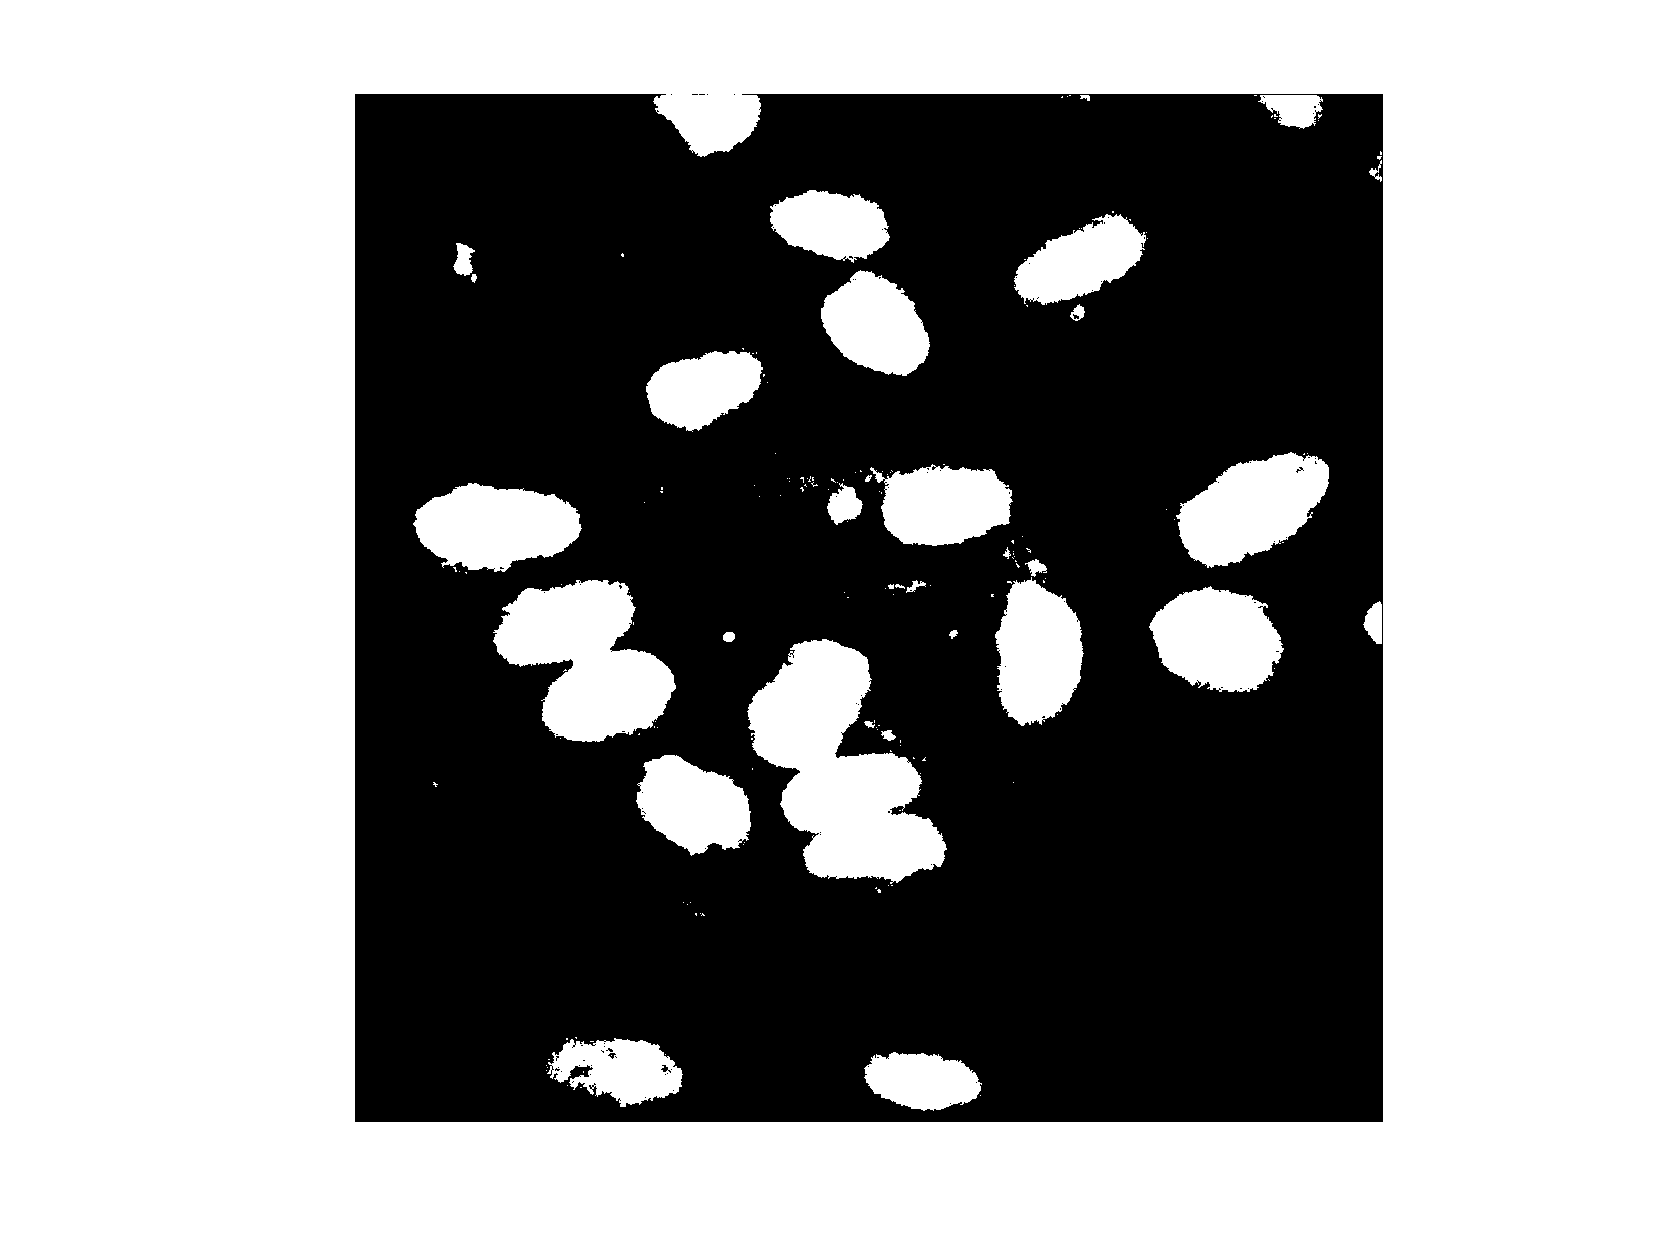

In [20]:
thr = 90;
bwImage = grayImage > thr;
figure
imshow(bwImage)


Now start counting the cells. Use the command <samp>regionprops</samp> to define the cells (white areas) and <samp>bwboundaries</samp> to draw boundaries around each cell


In [21]:
cells = regionprops(bwImage,"all");
boundaries = bwboundaries(bwImage,"noholes");


A user-defined minimal pixel count specifies criteria for defining cells and boundaries based on their total volume to reject small debris from being counted


In [22]:
minPixelCount = 200;
boundaries = boundaries([cells.Area] > minPixelCount);
cells = cells([cells.Area] > minPixelCount);
centroids = vertcat(cells.Centroid);


Plot the boundaries and centroids on top of the original image. The boundaries can be smoothed using the <samp>smoothingFactor</samp> user control object



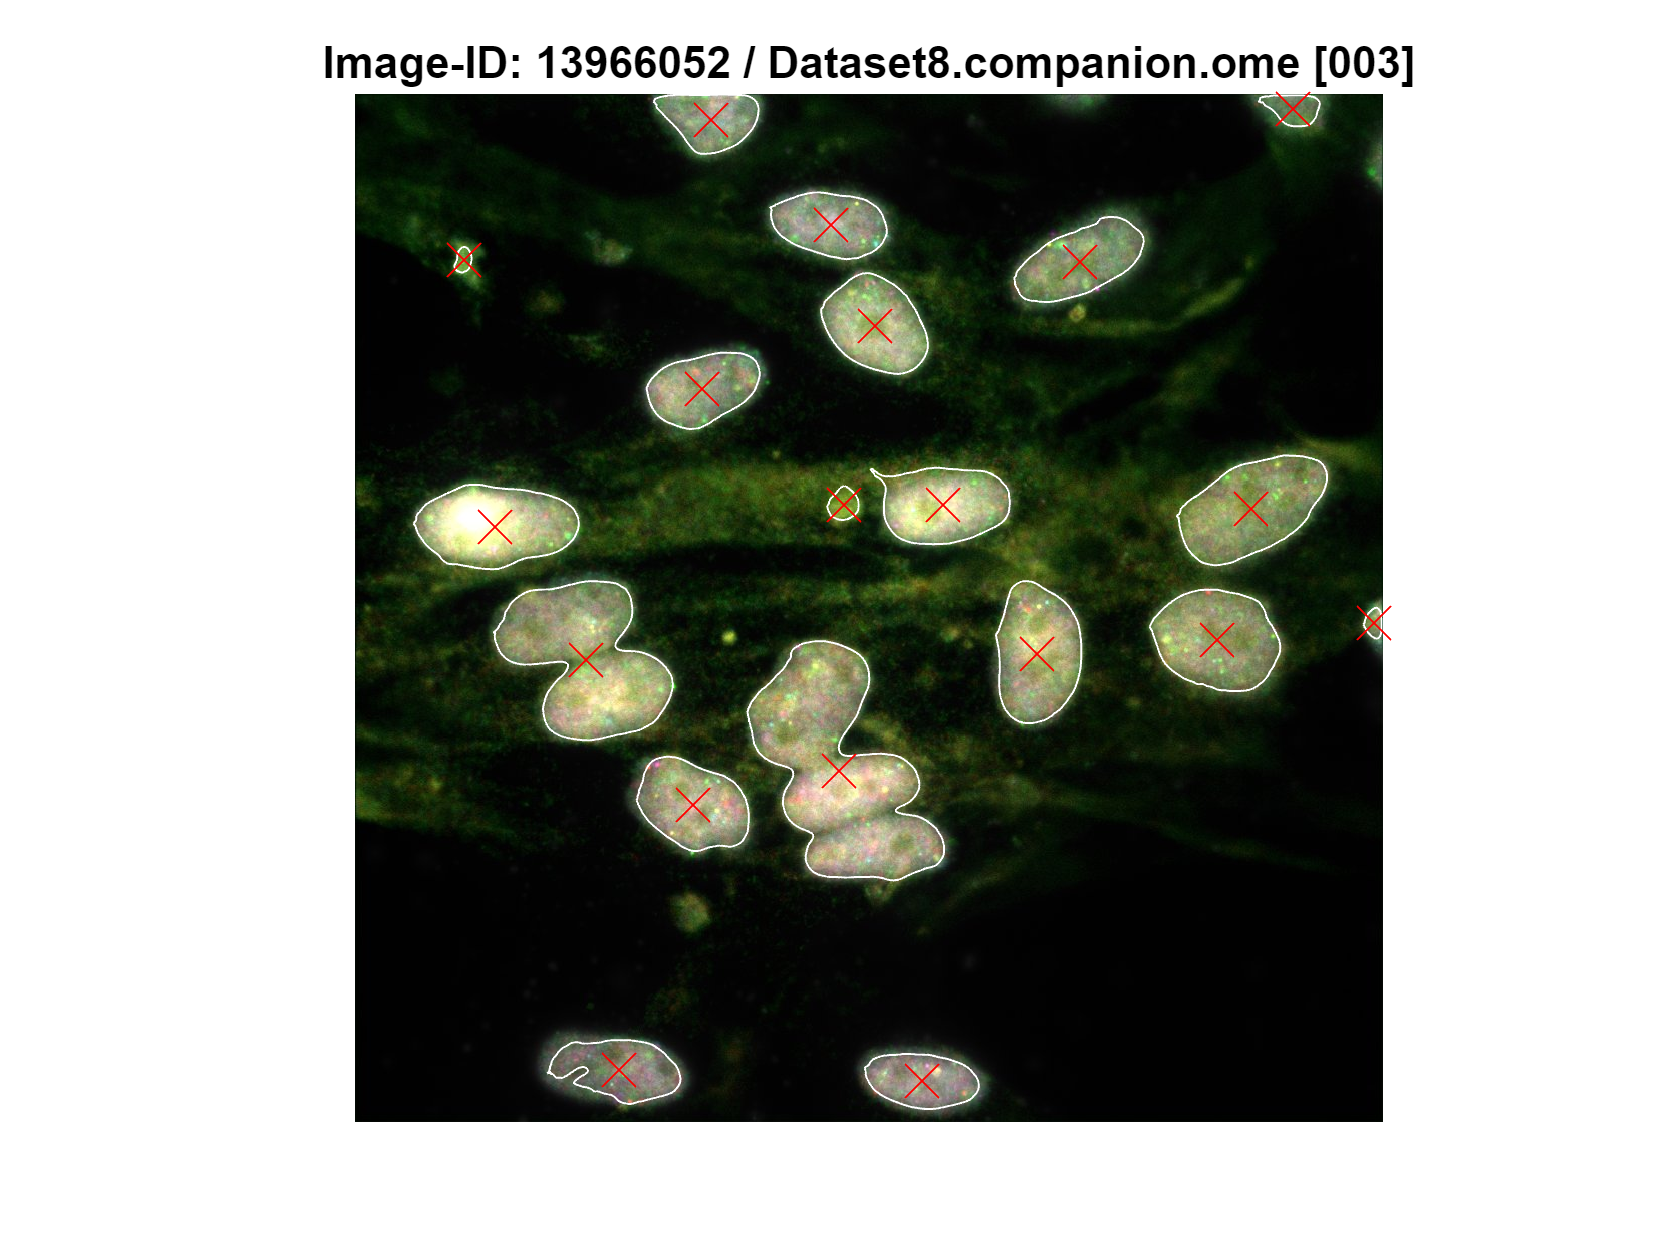

In [23]:
figure
imshow(fullImage);
smoothingFactor = 31;
hold on
for iBound = 1:numel(boundaries)
    thisBound = boundaries{iBound};
    plot(smooth(thisBound(:,2),smoothingFactor), smooth(thisBound(:,1),smoothingFactor), 'w', 'LineWidth', 0.5);
end
plot(centroids(:,1), centroids(:,2),"rx", "MarkerSize",12)
title("Image-ID: " + num2str(datasetImages.id(3)) + " / " + datasetImages.name(3), "Interpreter","none");

<a name="H_2C04E455"></a>
## Publish reusable MATLAB code for reproducible results
<a name="H_8025316E"></a>

To enable collaboration partners, reviewers and the community reuse your MATLAB code and reproduce your results.

-  Publish your MATLAB code (eg: on GitHub) and generate a [DOI](https://en.wikipedia.org/wiki/Digital_object_identifier) (digital object identifier) by [linking it to a DOI generating portal](https://docs.github.com/en/repositories/archiving-a-github-repository/referencing-and-citing-content)(egs. [Figshare](https://help.figshare.com/article/how-to-connect-figshare-with-your-github-account#:~:text=You%20can%20get%20set%20up,where%20you'll%20authorise%20figshare.), Zenodo). Make your research output findable by including as much information as needed in the metadata. Document your code well explaining steps required to reproduce clearly and explicitly.
-  Make sure you include a license for your code that specifies reuse and re-distribution rights for the code. Various open source licenses are [available](https://opensource.org/licenses/). BSD, MIT and Apache licenses are commonly used for open research software.
-  [Link your GitHub repository to File Exchange](https://www.mathworks.com/matlabcentral/content/fx/about.html?s_tid=gn_mlc_fx_help#Why_GitHub) to make your MATLAB code available to MATLAB users via the Add-Ons button.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 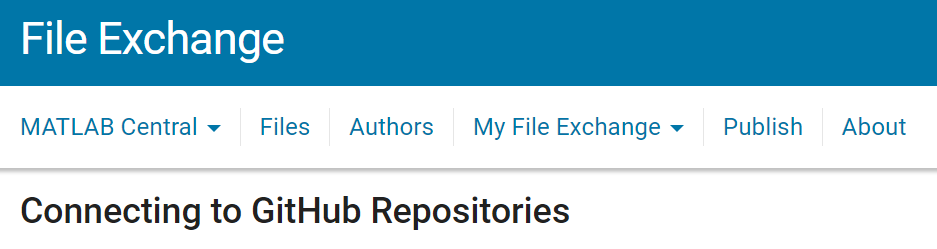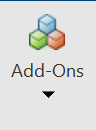

-  Make your MATLAB code **interoperable**. MATLAB is [interoperable](https://www.mathworks.com/products/matlab/matlab-and-other-programming-languages.html) with several other languages including C, Fortran and Python. MATLAB can be directly called from Python using the [MATLAB Engine for Python](https://www.mathworks.com/help/matlab/matlab-engine-for-python.html) which is available as a PyPI package and can be installed using the command <samp>pip install matlab.engine</samp> from Python. MATLAB code can also be [packaged as a Python library](https://www.mathworks.com/help/compiler_sdk/gs/create-a-python-application-with-matlab-code.html) and called from Python. Deep Learning models from other frameworks are [interoperable with MATLAB](https://www.mathworks.com/help/deeplearning/ug/interoperability-between-deep-learning-toolbox-tensorflow-pytorch-and-onnx.html) either using the [ONNX interface](https://www.mathworks.com/matlabcentral/fileexchange/67296-deep-learning-toolbox-converter-for-onnx-model-format) or via direct interfaces that exist, for example, for Pytorch and Tensorflow models.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 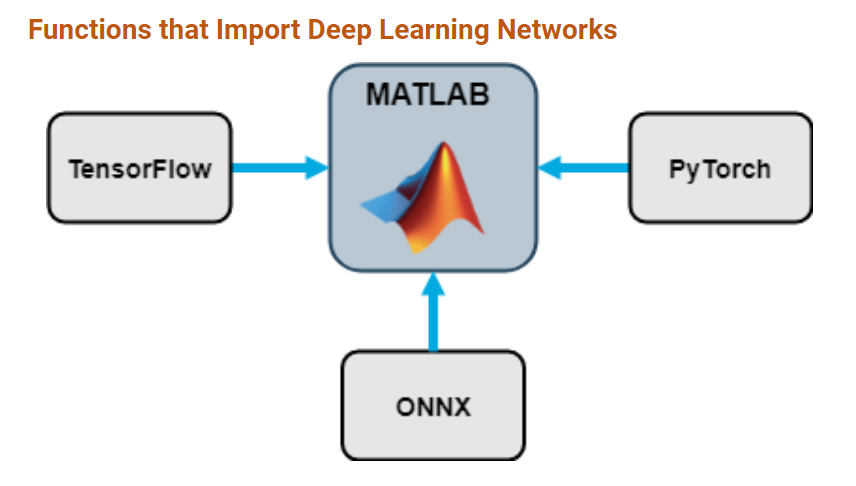

-  MATLAB is interoperable with cloud architectures such as [JupyterHub](https://www.mathworks.com/products/reference-architectures/jupyter.html) and MATLAB code can also be used within Jupyter Notebooks. Here is a link to a Jupyter notebook of the same example used here. There is an official MATLAB kernel for Jupyter Notebooks - read about it [here](https://blogs.mathworks.com/matlab/2023/01/30/official-mathworks-matlab-kernel-for-jupyter-released/).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 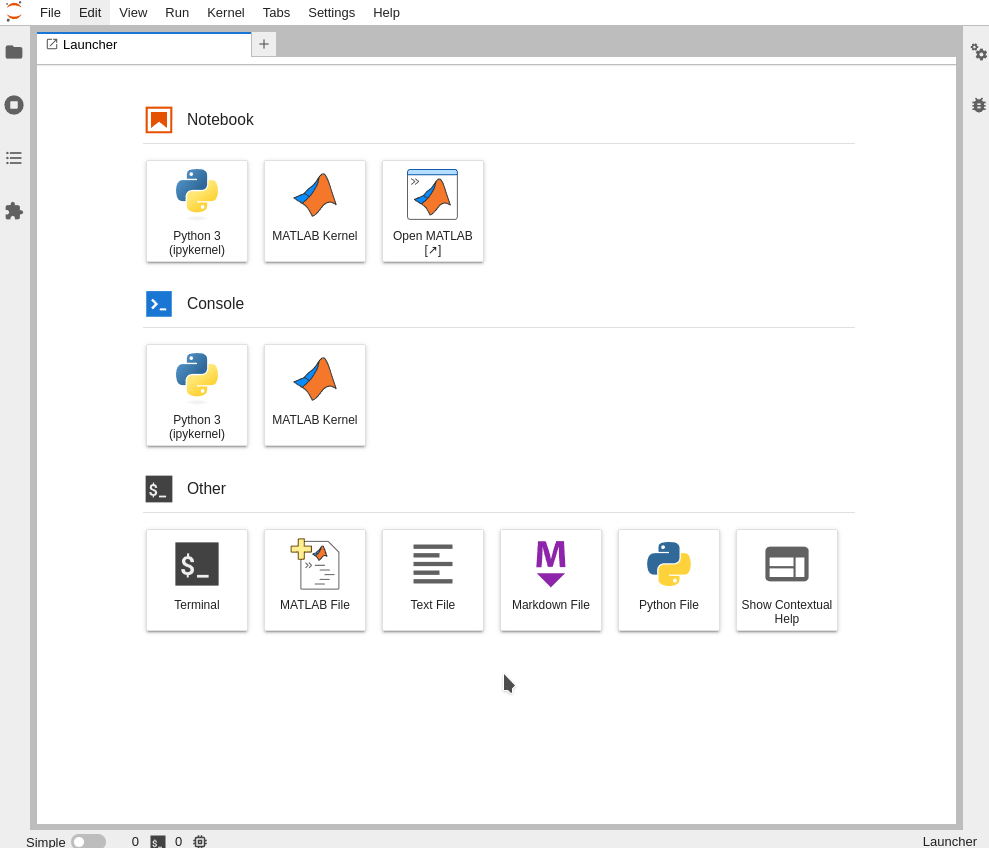

-  Run your [MATLAB code on the browser directly from GitHub](https://www.mathworks.com/help/matlab/matlab_env/open-github-repositories-in-matlab-online.html). Copy and paste the GitHub repo address into [this app](https://www.mathworks.com/products/matlab-online/git.html). That will generate a command, which when pasted into your README, will create a "Open in MATLAB Online" button on your GitHub repository. By clicking on this button, users will be able to run your code in the browser on MATLAB Online.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 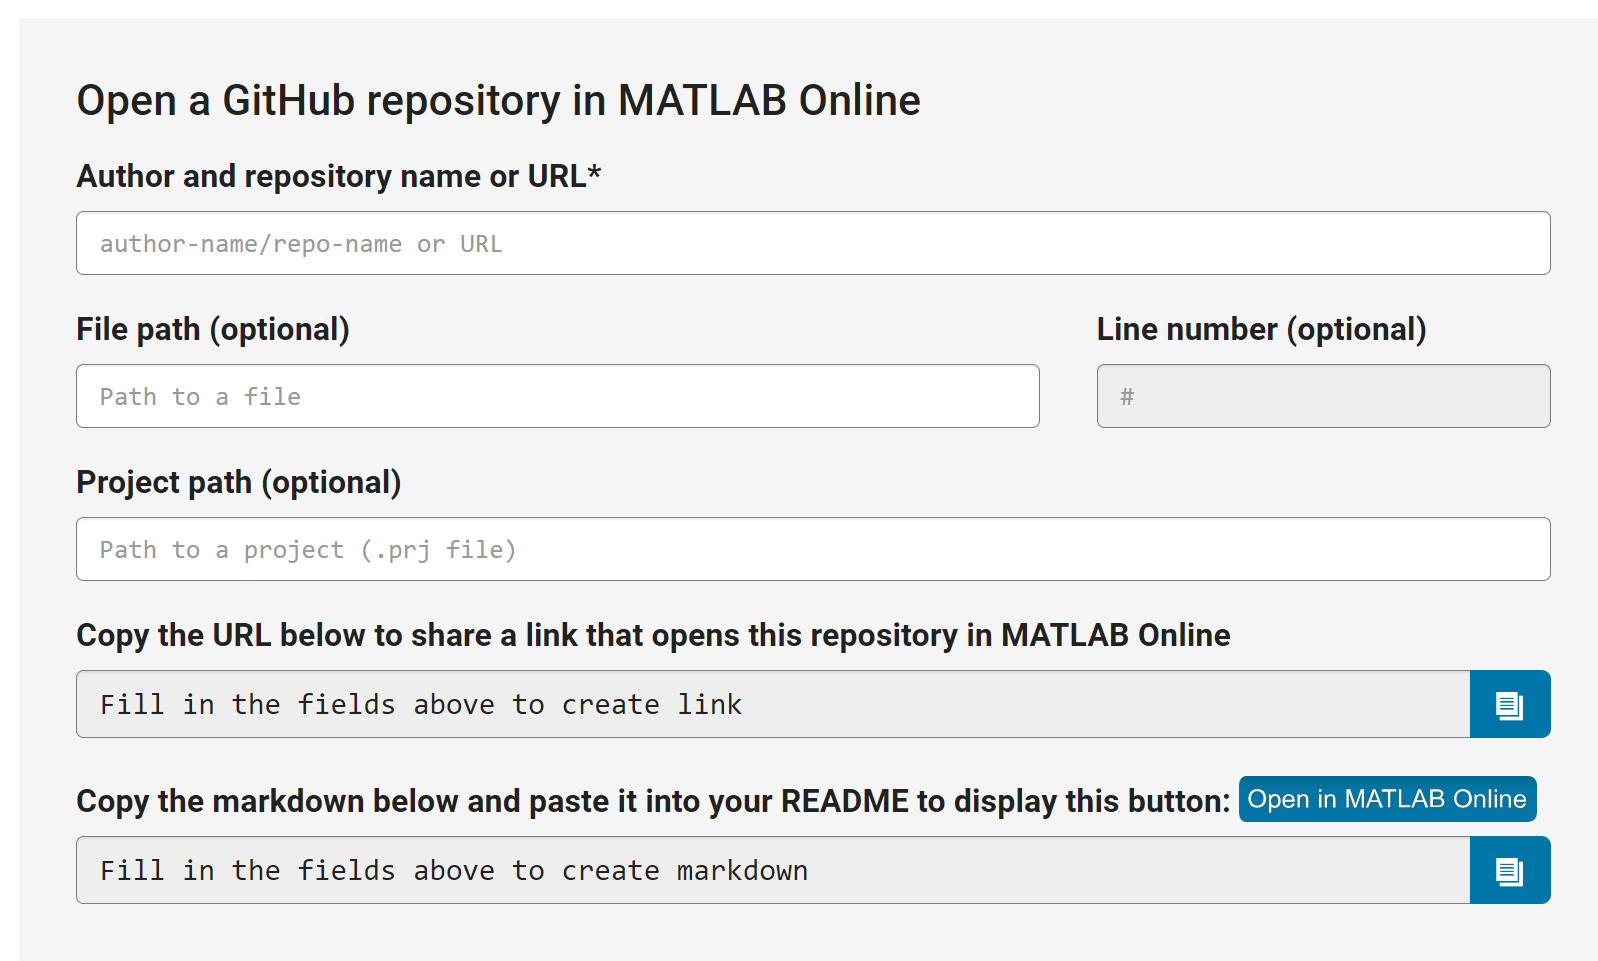

-  Make your MATLAB code reproducible by using a reproducibility portals that supports MATLAB. One example is Code Ocean. On Code Ocean, you can [upload your MATLAB code](https://help.codeocean.com/en/articles/1120384-which-toolboxes-are-included-with-matlab) including dependencies. Once uploaded, your code is tested and published as a Code Ocean "capsule" which can be run online or downloaded and run locally by users. Code Ocean also generates a DOI for your code capsule. For Live Scripts, convert the <samp>.mlx</samp> file into a <samp>.m</samp> file and a <samp>.html</samp> file using the [<samp>export</samp>](https://de.mathworks.com/help/matlab/ref/export.html) function for best results. [Here is the DOI](http://doi.org/10.24433/CO.8820386.v2) for the Code Ocean capsule of the this code. Read more about MATLAB on Code Ocean [here](https://blogs.mathworks.com/loren/2021/07/15/sharing-and-running-matlab-code-in-the-cloud/#H_795BB86B).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 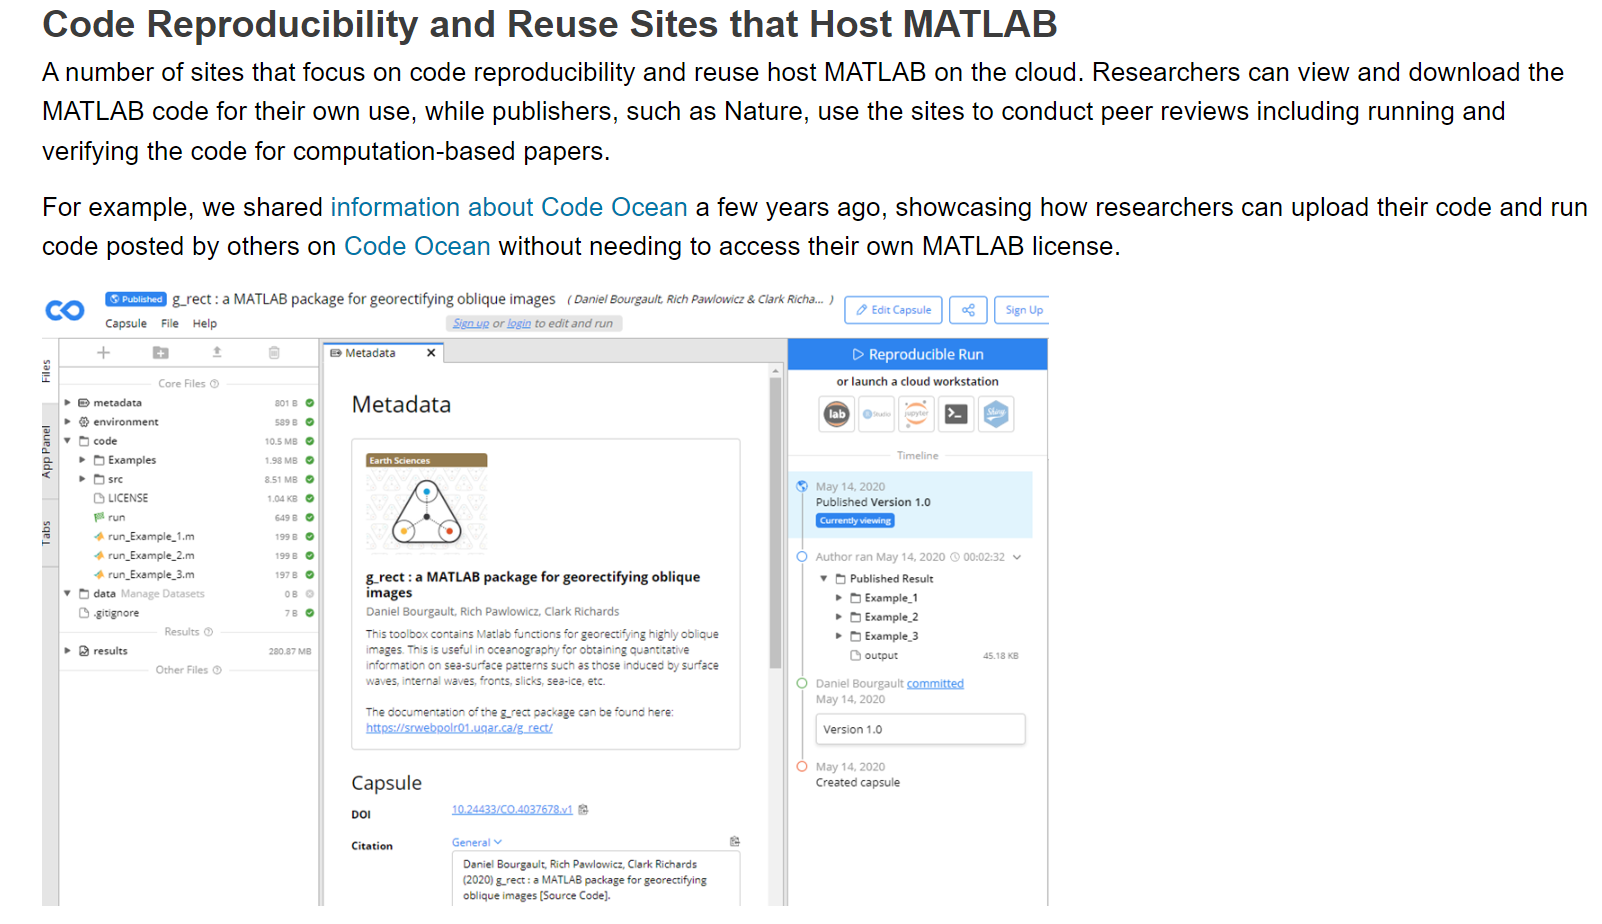

-  **Warning**: Before making your code available on the cloud, <u>make sure all dependencies including any data that is needed for your code to run is uploaded along with the code</u>. Also make sure any <u>path and/or filenames that refer to local directories are appropriately renamed</u>.
-  FAIR standards: FAIR is an acronym that stands for **F**indable, **A**ccessible, **I**nteroperable and **R**eproducible. It is an [accepted standard](https://www.nature.com/articles/s41597-022-01710-x) for research output (code, data) and is often required for your research results to be in [compliance with "Open Science" standards](https://research-and-innovation.ec.europa.eu/strategy/strategy-2020-2024/our-digital-future/open-science_en). Adhering to the above pointers helps in making your MATLAB code FAIR
